# SFA For Monkey Vocalization Identification

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import soundfile as sf 
import pyfilterbank.gammatone as g
import SFA_Tools.SFA_Sets as s
import scipy.ndimage.filters as filt
from sklearn import svm
from sklearn.linear_model import Perceptron
from tqdm import tqdm

## Initialize Variables

In [31]:
## Files for vocalizations and noise
load_noise = True
noise = None
noiselen = 100000
vocal_files = ['coo.WAV','grunt.WAV','AG493B.WAV','CS1E54.WAV']
noise_file = 'Matlab_SoundTextureSynth/Output_Folder/Bubbling_water_10111010100.wav'
num_vocals = len(vocal_files)

## Parameters for vocalization and noise preprocessing
signal_to_noise_ratio = 50
gfb = g.GammatoneFilterbank(order=1, density = 1.0, startband = -21, endband = 21, normfreq = 2200)
plot_gammatone_transformed = False
plot_temporal_filters = False
plot_temporal_transformed = True

## Parameters for training data
num_samples = num_vocals * 30
gaps = True
min_gap = 25
max_gap = 100
apply_noise = True

## Parameters for testing data
test_noise = True
plot_test = True
plot_features = True

classifier_baseline = Perceptron(max_iter = 1000, tol = 0.001)
classifier_SFA = Perceptron(max_iter = 1000, tol = 0.001)
classifier_features = 2

## Load In Files Containing Vocalizations And Noise

In [30]:
# Read and load vocalizations from a list of files
def get_data(file_list):
    vocalizations = []
    rate = 0
    for f in file_list:
        vocal, rate = sf.read(f)
        vocalizations.append(vocal)
    return vocalizations

# Compute the average power of a signal
def signal_power(sig):
    return np.sum(np.square(sig))/sig.size

# Scales a noise vector to have a specified signal-to-noise ratio with
# another waveform
def scale_noise(vocalizations, noise, ratio):
    data = np.zeros(1)
    for vocal in vocalizations:
        data = np.hstack((data,vocal))
        
    initial_ratio = signal_power(data)/signal_power(noise[:data.size])
    return noise * np.sqrt(initial_ratio/ratio)

# Applies a gammatone transform with a given filter bank to a waveform
def gamma_transform(data, filterbank):
    analysed = gfb.analyze(data)
    
    transformed = np.zeros((len(gfb.centerfrequencies),data.size))
    for i in range(len(gfb.centerfrequencies)):
        (band,state) = analysed.__next__()
        transformed[i] = abs(band)
        
    return transformed

# Applies a gammatone transform with given filter bank to a list of 
# different waveforms
def gamma_transform_list(data, filterbank):
    transformed = []
    
    for d in tqdm(data):
        d_transformed = gamma_transform(d, filterbank)
        transformed.append(d_transformed)
        
    return transformed

# Plots gammatone transformed vocalizations effectively
def plot_input(inp, name):
    plt.figure(figsize=(12,3))
    plt.title(name)
    plt.imshow(inp, aspect = 'auto')
    plt.show()
    return

# Gamma Function
def gamma(n, a, b, m):
    arr = np.arange(1,n+1)
    return a*np.power(arr,m)*(np.exp(-b*arr))

# Creates a temporal filter
def temporalFilter():
    arr = gamma(400,1.5,0.04,2) - gamma(400,1,0.036,2) 
    arr = arr / np.var(arr)
    return arr

# Applies list of temporal filters to a transformed vocal
def temporal_transform(data,filters):
    transformed = None
    init = True
    for f in filters:
        filtered = filt.convolve(data,f[:,None].T)
        if(init):
            transformed = filtered
            init = False
        else:
            transformed = np.vstack((transformed,filtered))
            
    return transformed

# Applies list of temporal filters to a list of transformed vocals
def temporal_transform_list(data,filters):
    transformed = []
    
    for d in tqdm(data):
        d_transformed = temporal_transform(d, filters)
        transformed.append(d_transformed)
        
    return transformed

def getSF(data,name, mode = 'quad', retain = 20, transform = False):
    (data_normalized,mean,variance) = s.norm(data)
    print(name, ': Normalization Complete...')
    
    if (mode == 'quad'):
        data_normalized = s.quadExpand(data_normalized)
    print(name, ': Nonlinear Expansion Complete...')
    
    (data_Sphered,data_SS) = s.PCA(data_normalized)
    print(name, ': Sphering Complete...')
    
    weights = s.weights(data_Sphered, retain)    
    weights = np.flip(weights.T,0)
    print(name, ': Weights Determined...')
    
    if(transform):
        transformed = weights @ data_Sphered
        return transformed, mean, variance, data_SS, weights
    else:
        return mean, variance, data_SS, weights

def testSF(data, name, mean, variance, SS, weights, mode = 'quad'):
    data_normalized = s.normTest(data, mean, variance) 
    print(name, ': Normalization Complete...')
    
    if (mode == 'quad'):
        data_normalized = s.quadExpand(data_normalized)
    print(name, ': Nonlinear Expansion Complete...')
    
    data_Sphered = s.PCATest(data_normalized,SS)
    print(name, ': Sphering Complete...')
    
    return weights @ data_Sphered

def getlabels(data):
    labels = None
    initialized = False
    for i,d in enumerate(data):
        if(not(initialized)):
            labels = np.zeros(d[0].size)
            initialized = True
        else:
            nextlabel = np.ones(d[0].size) * i
            labels = np.hstack((labels,nextlabel))
    return labels


In [13]:
vocalizations = get_data(vocal_files)
print('Vocalizations Loaded...')

if(load_noise):
    noise, _ = sf.read(noise_file)

print('Noises loaded...')
print('Ready for preprocessing.')

Vocalizations Loaded...
Noises loaded...
Ready for preprocessing.


## Preprocess Vocalizations And Noise

### Adjusting Noise For Signal To Noise Ratio

In [14]:
noise = scale_noise(vocalizations,noise,signal_to_noise_ratio)
noise = noise[:noiselen]
print('Noise Scaled...')
print('Ready For Gammatone Transform')

Noise Scaled...
Ready For Gammatone Transform


### Apply Gammatone Transform 

In [15]:
vocals_transformed = gamma_transform_list(vocalizations, gfb)
print('Vocalizations Transformed...')

noise_transformed = gamma_transform(noise, gfb)
print('Noise Transformed...')

if(plot_gammatone_transformed):
    for i,vocal in enumerate(vocals_transformed):
        plot_input(vocal, vocal_files[i])
    plot_input(noise_transformed, 'Noise')
    
print('Ready For Temporal Filters')

100%|██████████| 4/4 [00:00<00:00, 14.34it/s]


Vocalizations Transformed...
Noise Transformed...
Ready For Temporal Filters


### Apply Temporal Filters

100%|██████████| 4/4 [00:09<00:00,  2.57s/it]


Vocals Temporally Filtered...
Noise Temporraly Filtered


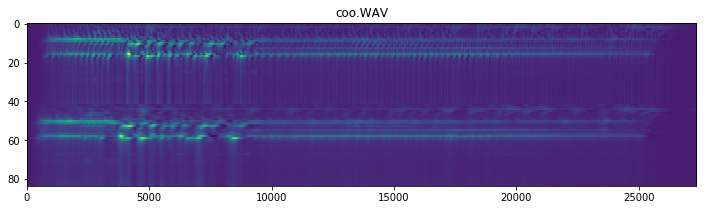

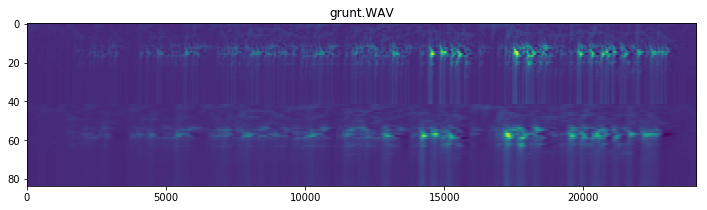

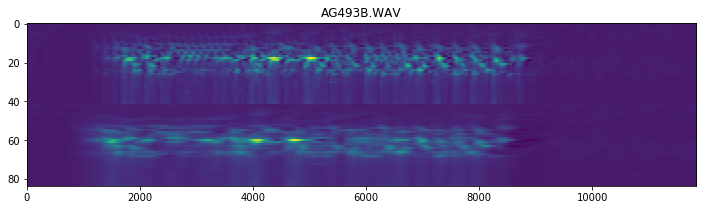

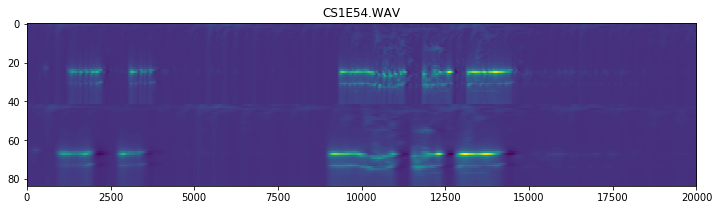

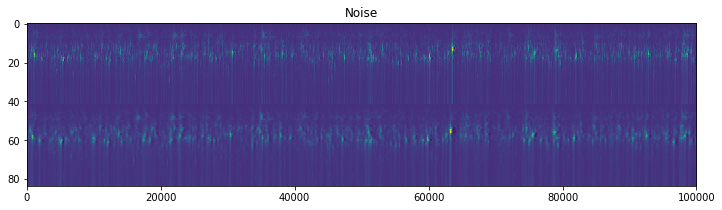

Ready For SFA


In [16]:
tFilter = temporalFilter()
tFilter2 = np.repeat(tFilter,3)/3
tFilters = [tFilter, tFilter2]

if(plot_temporal_filters):
    plt.plot(tFilter)
    plt.plot(tFilter2)
    plt.show()

vocals_temporal_transformed = temporal_transform_list(vocals_transformed,tFilters)
print('Vocals Temporally Filtered...')

noise_temporal_transformed = temporal_transform(noise_transformed,tFilters)
print('Noise Temporraly Filtered')

if(plot_temporal_transformed):
    for i,vocal in enumerate(vocals_temporal_transformed):
        plot_input(vocal, vocal_files[i])
    plot_input(noise_temporal_transformed, 'Noise')

print('Ready For SFA')

### Create Training Dataset

In [17]:
samples = np.random.randint(num_vocals, size = num_samples)

training_data = None
initialized = False
for i in tqdm(samples):
    if(not(initialized)):
        training_data = vocals_temporal_transformed[i]
        initialized = True
    else:
        training_data = np.concatenate((training_data, vocals_temporal_transformed[i]),1)
        
    if(gaps):
        training_data = np.concatenate((training_data, np.zeros((training_data.shape[0], np.random.randint(min_gap,max_gap)))),1)     
print('Data arranged...')

if(apply_noise):
    training_data = training_data + noise_temporal_transformed[:,0:training_data[0].size]
    print('Applied Noise...')
else:
    print('No Noise Applied...')

print('Ready For SFA')

100%|██████████| 120/120 [00:00<00:00, 400.01it/s]

Data arranged...
Applied Noise...
Ready For SFA


## Train SFA On Data

In [18]:
(mean, variance, data_SS, weights) = getSF(training_data, 'Layer 1')

print('SFA Training Complete')

Layer 1 : Normalization Complete...
Layer 1 : Nonlinear Expansion Complete...
Layer 1 : Sphering Complete...
Layer 1 : Weights Determined...
SFA Training Complete


## Test SFA Results

### Create Test Data

100%|██████████| 4/4 [00:00<00:00, 26.27it/s]


Data arranged...
Applied Noise...


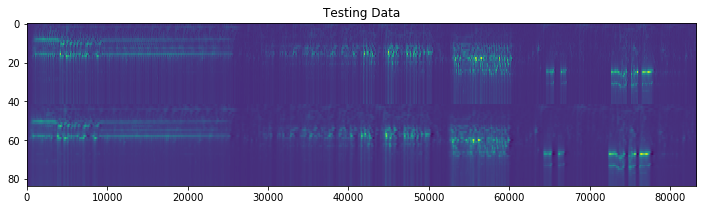

Testing Data Ready


In [20]:
samples = np.arange(num_vocals)

testing_data = None
initialized = False
for i in tqdm(samples):
    if(not(initialized)):
        testing_data = vocals_temporal_transformed[i]
        initialized = True
    else:
        testing_data = np.concatenate((testing_data, vocals_temporal_transformed[i]),1) 
print('Data arranged...')

if(test_noise):
    testing_data = testing_data + noise_temporal_transformed[:,0:testing_data[0].size]
    print('Applied Noise...')
else:
    print('No Noise Applied...')

if(plot_test):
    plot_input(testing_data, 'Testing Data')
print('Testing Data Ready')

### Apply SFA To Test Set

In [21]:
test = testSF(testing_data, 'Layer 1', mean, variance, data_SS, weights)
print('SFA Applied To Test Set')

Layer 1 : Normalization Complete...
Layer 1 : Nonlinear Expansion Complete...
Layer 1 : Sphering Complete...


### Plot SFA Features

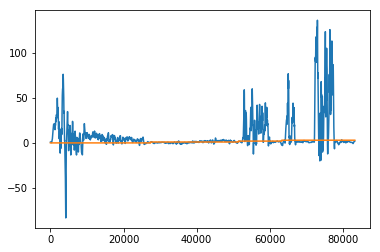

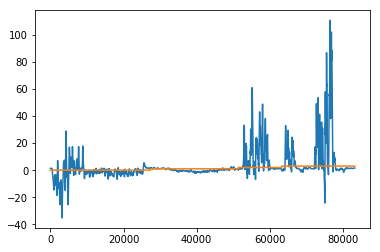

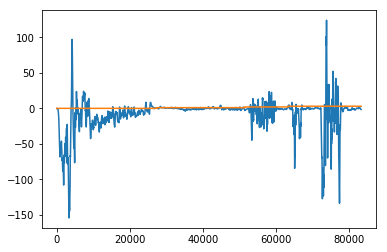

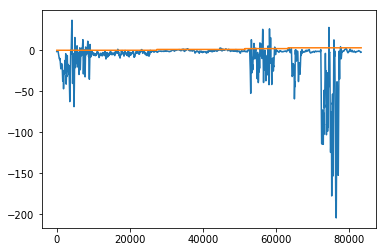

In [29]:
labels = getlabels(vocals_temporal_transformed)

if(plot_features):
    for i in range(4):
        plt.plot(test[i])
        plt.plot(labels)
        plt.show() 
    print('SFA Features Plotted')
else:
    print('Skipping Feature Plotting')

### Compare SFA With Baseline For Linear Classification

In [34]:
print('SFA Based Classifier with ', classifier_features, ' features')
classifier_SFA.fit(test[:classifier_features].T,labels)
print(classifier_SFA.score(test[:classifier_features].T,labels), '\n')

print('Baseline Classifier with ', classifier_features, ' features')
classifier_baseline.fit(testing_data.T,labels)
print(classifier_baseline.score(testing_data.T,labels))

SFA Based Classifier with  2  features
0.4065716310182906 

Baseline Classifier with  2  features
0.9865973314758548
